#Model Performances without Preprocessing
[Main Notebook Link ](https://https://colab.research.google.com/drive/1VoNd7GfqIoVJs2gRqsmb7OUwlfWEwPEB#scrollTo=it0R6CN3a9ma)

##Installs

In [2]:
#Installs
!pip install pydot --quiet
!pip install gensim==3.8.3 --quiet
!pip install tensorflow-datasets --quiet
!pip install -U tensorflow-text==2.8.2 --quiet
!pip install transformers --quiet
!pip install datasets 
!pip3 install emoji==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 63.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.1/498.1 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 94.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 73.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 kB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 78.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 99.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 20.4 MB/s eta 0:00:00
Lo

##Imports


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

from transformers import BertTokenizer, TFBertModel, AutoModel, AutoTokenizer, TFAutoModelForSequenceClassification, TFAutoModel, RobertaTokenizer

import nltk
from nltk.corpus import reuters
from nltk.data import find
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import wordpunct_tokenize
from nltk.tokenize import TweetTokenizer

import sklearn as sk
import os

import matplotlib.pyplot as plt

import re

#This continues to work with gensim 3.8.3.  It doesn't yet work with 4.x.  
#Make sure your pip install command specifies gensim==3.8.3
import gensim

In [4]:
from sklearn.metrics import classification_report
import seaborn as sns

##DataSet Import

In [5]:
import datasets 
dataset = datasets.load_dataset('ucberkeley-dlab/measuring-hate-speech', 'binary')   
df = dataset['train'].to_pandas()

##Citation
##@article{kennedy2020constructing,
  #title={Constructing interval variables via faceted Rasch measurement and multitask deep learning: a hate speech application},
  #author={Kennedy, Chris J and Bacon, Geoff and Sahn, Alexander and von Vacano, Claudia},
  #journal={arXiv preprint arXiv:2009.10277},
  #year={2020}
#}

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/ucberkeley-dlab___parquet/ucberkeley-dlab--measuring-hate-speech-c32713cabe528196/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
# list of all the columns in the dataframe
for i in df.columns:
  print(i)

comment_id
annotator_id
platform
sentiment
respect
insult
humiliate
status
dehumanize
violence
genocide
attack_defend
hatespeech
hate_speech_score
text
infitms
outfitms
annotator_severity
std_err
annotator_infitms
annotator_outfitms
hypothesis
target_race_asian
target_race_black
target_race_latinx
target_race_middle_eastern
target_race_native_american
target_race_pacific_islander
target_race_white
target_race_other
target_race
target_religion_atheist
target_religion_buddhist
target_religion_christian
target_religion_hindu
target_religion_jewish
target_religion_mormon
target_religion_muslim
target_religion_other
target_religion
target_origin_immigrant
target_origin_migrant_worker
target_origin_specific_country
target_origin_undocumented
target_origin_other
target_origin
target_gender_men
target_gender_non_binary
target_gender_transgender_men
target_gender_transgender_unspecified
target_gender_transgender_women
target_gender_women
target_gender_other
target_gender
target_sexuality_bisexu

In [7]:
# creating arrays of text column and labels column for viewing and making text columns str
df['text'].astype(str)
df = df[['text', 'hate_speech_score']].groupby('text').mean().reset_index()
text = np.array(df['text'])
labels = np.array(df['hate_speech_score'])

##EDA

<Axes: ylabel='Count'>

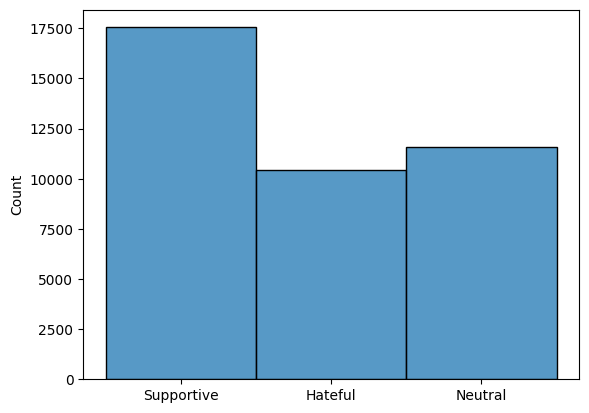

In [15]:
##EDA
import seaborn as sns
def str_labler(arr):
  new_arr = []
  for i in arr:
    if i >= .5:
      new_arr.append("Hateful")
    elif i < .5 and i > -1:
      new_arr.append("Neutral")
    else:
      new_arr.append("Supportive")
  return new_arr
labels_str = str_labler(labels)
sns.histplot(labels_str)

In [16]:
supp_count = len([i for i in labels_str if i =="Supportive"])
hate_count = len([i for i in labels_str if i =="Hateful"])
neut_count = len([i for i in labels_str if i =="Neutral"])
total_count = len(labels_str)
print("Supportive Count: ", supp_count)
print("Supportive Prop: ", supp_count/total_count)
print("Hateful Count: ", hate_count)
print("Hateful Prop: ", hate_count/total_count)
print("Neutral Count: ", neut_count)
print("Neutral Prop: ", neut_count/total_count)

Supportive Count:  17553
Supportive Prop:  0.4436496903829142
Hateful Count:  10437
Hateful Prop:  0.2637937571085555
Neutral Count:  11575
Neutral Prop:  0.29255655250853024


In [17]:
supp_exs = df[df['hate_speech_score'] < -1].sort_values('hate_speech_score')
hate_exs = df[df['hate_speech_score'] > .5].sort_values('hate_speech_score', ascending = False)
neut_exs = df[df['hate_speech_score'].between(-1,.3)]
hate_neut_edge_exs = df[df['hate_speech_score'].between(.3,.7)]

In [18]:
supp_exs

,hate_speech_score,text,2class_hate_speech


In [19]:
hate_exs

,hate_speech_score,text,2class_hate_speech
0,2,! thank u! im transmasc and generally present ...,0
22476,2,My masculine is awakening from my spiritual el...,0
22484,2,My masculine is awakening through my spiritual...,0
22483,2,My masculine is awakening my from my spiritual...,0
22482,2,My masculine is awakening from my spiritual up...,0
...,...,...,...
19468,1,Islam needs to be fucking destroyed.,1
19467,1,Islam kills gays. Nothing to do with you being...,1
12330,1,Fuck yourself bitch,1
19462,1,"Islam is bullsh#t.. a butch a beating, butcher...",1


In [20]:
neut_exs[neut_exs['hate_speech_score'].between(-.01,.01)]

,hate_speech_score,text,2class_hate_speech
8,0,""" Fuck you niggas ion give a fuck no more nigg...",0
10,0,""" I got women tryna sneak me through there doo...",0
11,0,""" I wish ur crack mom aborted you"" well guess ...",0
12,0,""" Pray for him"" ha! The filthy traitor would b...",0
15,0,""" is dat so hard for yu niggas to do😕 y'all wa...",0
...,...,...,...
39543,0,😡Vandals destroy Christian cemetery in Israel ...,0
39546,0,😭😭😭so litt sus with the right bitch tho none o...,0
39553,0,🤐 shhhhh them yung buls always wanna give me t...,0
39557,0,🤣 this nigga shot out,0


In [21]:
hate_neut_edge_exs.sort_values('hate_speech_score', ascending = False)

,hate_speech_score,text,2class_hate_speech


##Pre-Processing

In [8]:
def labler(arr):
  new_arr = []
  for i in arr:
    if i >= .5:
      new_arr.append(1)
    elif i < .5 and i > -1:
      new_arr.append(0)
    else:
      new_arr.append(2)
  return new_arr

In [9]:
#https://www.educative.io/answers/remove-all-the-punctuation-marks-from-a-sentence-using-regex


In [10]:
#labels = labler(labels)
new_df = df.apply(lambda x: labler(x) if x.name == 'hate_speech_score' else x,
                axis = 0)

In [11]:
new_df['hate_speech_score'].value_counts()

2    17553
0    11575
1    10437
Name: hate_speech_score, dtype: int64

In [12]:
new_df['2class_hate_speech'] = [0 if i in [0,2] else 1 for i in new_df['hate_speech_score'].values]

In [13]:
new_df['2class_hate_speech'].value_counts()

0    29128
1    10437
Name: 2class_hate_speech, dtype: int64

In [14]:
np.random.seed(6543)
grouped = new_df[['hate_speech_score', 'text', '2class_hate_speech']].groupby('hate_speech_score', as_index = False).apply(lambda x: x).reset_index()
df = grouped[['hate_speech_score', 'text', '2class_hate_speech']]
df

<ipython-input-14-aefeba8d0452>:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grouped = new_df[['hate_speech_score', 'text', '2class_hate_speech']].groupby('hate_speech_score', as_index = False).apply(lambda x: x).reset_index()


,hate_speech_score,text,2class_hate_speech
0,2,! thank u! im transmasc and generally present ...,0
1,1,!Go fuck yourself faggot!,1
2,2,!flair [I love women and minorities],0
3,1,!flair [death to all niggers and gays],1
4,2,""" 'convoluted' genealogy of Jesus""; was that c...",0
...,...,...,...
39560,1,🤧 The limousine liberal Jews and WASPs who wa...,1
39561,0,🤬CONGRATULATIONS #MARYLAND #BALTIMORE LIBERALS...,0
39562,1,🥳 another bitch will when another bitch can't,1
39563,2,🥴🥴 next time stay your ass in the car before o...,0


##Train/Test/Val Split

In [22]:
np.random.seed(6543)
shuffle = np.random.permutation(np.arange(df.shape[0]))

train_data, val_data, test_data = df.iloc[shuffle][:round(len(df)*.7)], df.iloc[shuffle][round(len(df)*.7):round(len(df)*.85)], df.iloc[~shuffle][round(len(df)*.85):round(len(df))]

train_examples, train_labels = train_data['text'], np.array(train_data['hate_speech_score'])
val_examples, val_labels = val_data['text'], np.array(val_data['hate_speech_score'])
test_examples, test_labels = test_data['text'], np.array(test_data['hate_speech_score'])
binary_train_examples, binary_train_labels = train_data['text'], np.array(train_data['2class_hate_speech'])
binary_val_examples, binary_val_labels = val_data['text'], np.array(val_data['2class_hate_speech'])
binary_test_examples, binary_test_labels = test_data['text'], np.array(test_data['2class_hate_speech'])

In [23]:
train_data['2class_hate_speech'].value_counts()

0    20368
1     7328
Name: 2class_hate_speech, dtype: int64

In [24]:
print(len(train_examples) == len(train_labels))
print(len(val_examples) == len(val_labels))
print(len(test_examples) == len(test_labels))

True
True
True


In [25]:
print(train_labels[:10])
print(train_data['hate_speech_score'][:10].values)

[1 0 1 2 2 0 2 0 0 2]
[1 0 1 2 2 0 2 0 0 2]


In [26]:
val_data['hate_speech_score'].value_counts()

2    2667
0    1710
1    1557
Name: hate_speech_score, dtype: int64

<Axes: xlabel='hate_speech_score', ylabel='text'>

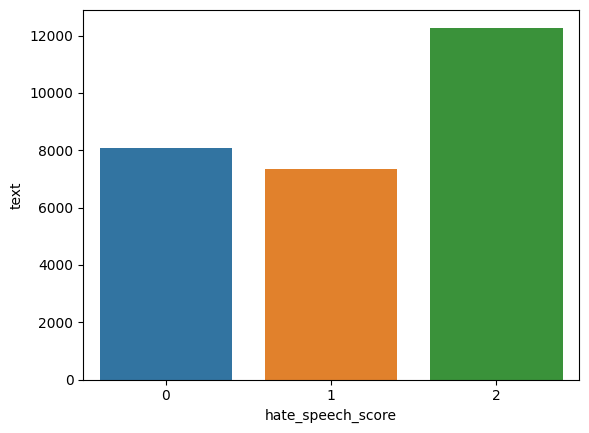

In [27]:
labels1 = train_data.groupby('hate_speech_score').agg('count')
sns.barplot(x = labels1.index, y = labels1['text'])

##Regular Tokenization

In [ ]:
tokenizer = tf_text.WhitespaceTokenizer()
train_tokens = tokenizer.tokenize(train_examples)
val_tokens = tokenizer.tokenize(val_examples)
test_tokens = tokenizer.tokenize(test_examples)

In [ ]:
max([len(i) for i in train_tokens.numpy()])

128

In [ ]:
np.mean([len(i) for i in train_tokens.numpy()])

24.54015873015873

In [ ]:
np.median([len(i) for i in train_tokens.numpy()])

19.0

## Baseline

In [ ]:
def baseline_model(lbls):
  guesses = []
  for i in range(len(lbls)):
    x = np.random.uniform(low=0, high=1)
    if x <= supp_count/total_count:
      guesses.append(2)
    elif x <= (supp_count + hate_count)/total_count and x > supp_count/total_count:
      guesses.append(1)
    elif x > (supp_count + hate_count)/total_count and x<=1:
      guesses.append(0)
  return guesses

In [ ]:
baseline_guesses = baseline_model(test_labels)

In [ ]:
baseline_accuracy = np.mean([1 if baseline_guesses[i] == test_labels[i] else 0 for i in range(len(test_labels))])
baseline_accuracy

0.3486099410278012

In [ ]:
print(classification_report(test_labels, baseline_guesses))

              precision    recall  f1-score   support

           0       0.30      0.30      0.30      1750
           1       0.26      0.26      0.26      1576
           2       0.43      0.44      0.44      2609

    accuracy                           0.35      5935
   macro avg       0.33      0.33      0.33      5935
weighted avg       0.35      0.35      0.35      5935



In [ ]:
cm = tf.math.confusion_matrix(test_labels, baseline_guesses)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(220.72222222222223, 0.5, 'True')

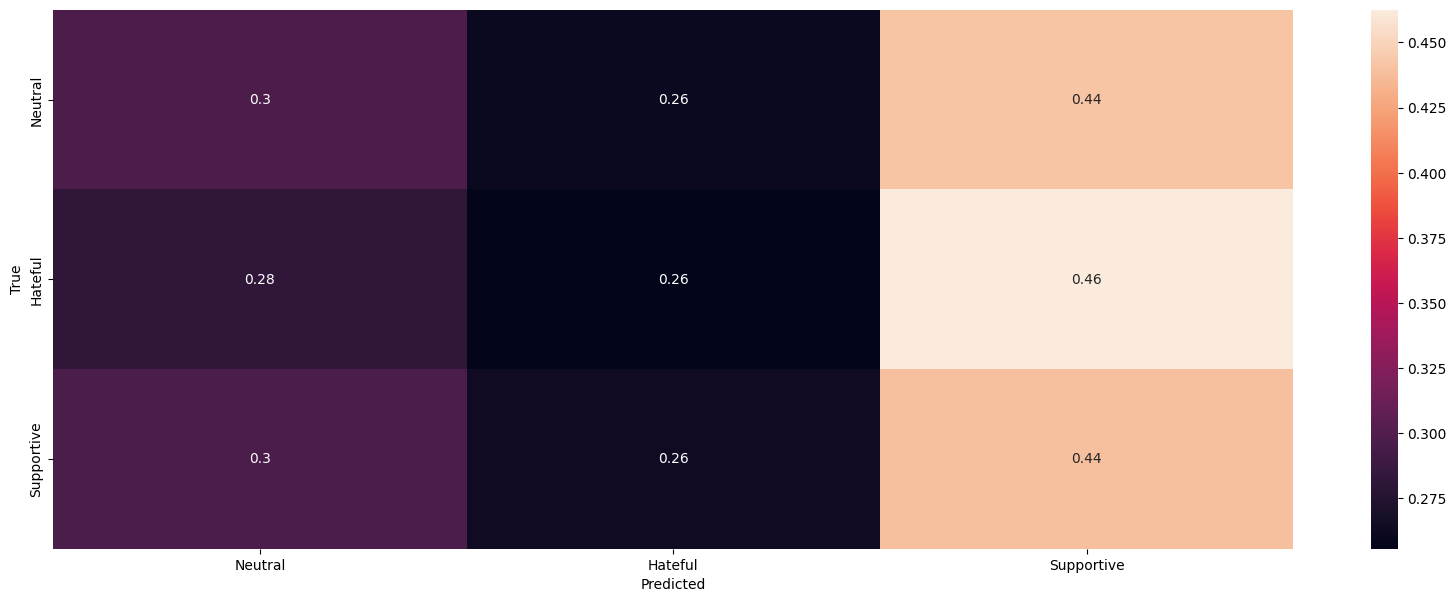

In [ ]:
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=["Neutral", "Hateful", "Supportive"],
    yticklabels=["Neutral", "Hateful", "Supportive"])
plt.xlabel("Predicted")
plt.ylabel("True")

## Bert Tokenization


In [ ]:
#Train and Test for Bert Based Models
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

MAX_SEQUENCE_LENGTH = 128

bert_train_tokenized = bert_tokenizer(list(train_examples),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
bert_train_inputs = [bert_train_tokenized.input_ids,
                     bert_train_tokenized.token_type_ids,
                     bert_train_tokenized.attention_mask]
bert_train_labels = np.array(train_labels)

bert_val_tokenized = bert_tokenizer(list(val_examples),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
bert_val_inputs = [bert_val_tokenized.input_ids,
                     bert_val_tokenized.token_type_ids,
                     bert_val_tokenized.attention_mask]
bert_val_labels = np.array(val_labels)

bert_test_tokenized = bert_tokenizer(list(test_examples),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
bert_test_inputs = [bert_test_tokenized.input_ids,
                     bert_test_tokenized.token_type_ids,
                     bert_test_tokenized.attention_mask]
bert_test_labels = np.array(test_labels)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
#max(len(x) for x in bert_train_inputs)
np.unique(bert_train_labels[:5000], return_counts =True)

(array([0, 1, 2]), array([1434, 1340, 2226]))

##BERT CLS

In [ ]:
#BERT Base Case
def create_bert_cls_classification_model(max_sequence_length=MAX_SEQUENCE_LENGTH,
                          dropout = 0.3,
                          hidden_size = 100, 
                          learning_rate=0.00001):
    """
    Build a  classification model with BERT, where you apply CNN layers  to the BERT output
    """


    bert_model.trainable = True
    max_length = MAX_SEQUENCE_LENGTH
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      

    bert_out = bert_model(bert_inputs)

    cls_token = bert_out[0][:, 0, :]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    classification = tf.keras.layers.Dense(3, activation='softmax',name='classification_layer', kernel_regularizer='l1')(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                                 metrics='accuracy')
    
    return classification_model

In [ ]:
bert_cls_classification_model = create_bert_cls_classification_model()
bert_cls_classification_model.summary()
#confirm all layers are frozen
bert_cls_classification_model_history = bert_cls_classification_model.fit(
    [bert_train_inputs[0], bert_train_inputs[1], bert_train_inputs[2]],
    bert_train_labels,
    validation_data=([bert_val_inputs[0], bert_val_inputs[1], bert_val_inputs[2]], bert_val_labels),
    batch_size=8,
    epochs=2)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                              

3462/3462 [==============================] - 825s 235ms/step - loss: 1.1745 - accuracy: 0.6077 - val_loss: 1.0605 - val_accuracy: 0.6635
Epoch 2/2
3462/3462 [==============================] - 813s 235ms/step - loss: 0.9898 - accuracy: 0.6909 - val_loss: 1.0136 - val_accuracy: 0.6663


In [ ]:
cls_predictions = bert_cls_classification_model.predict([bert_test_inputs[0], bert_test_inputs[1], bert_test_inputs[2]])
cls_predictions = tf.argmax(cls_predictions, axis=-1)

In [ ]:
print(classification_report(bert_test_labels, cls_predictions))#, target_names=["Neutral", "Hateful", "Supportive"]))

              precision    recall  f1-score   support

           0       0.65      0.55      0.59      1750
           1       0.73      0.84      0.78      1576
           2       0.85      0.85      0.85      2609

    accuracy                           0.76      5935
   macro avg       0.74      0.75      0.74      5935
weighted avg       0.76      0.76      0.76      5935



Text(220.72222222222223, 0.5, 'True')

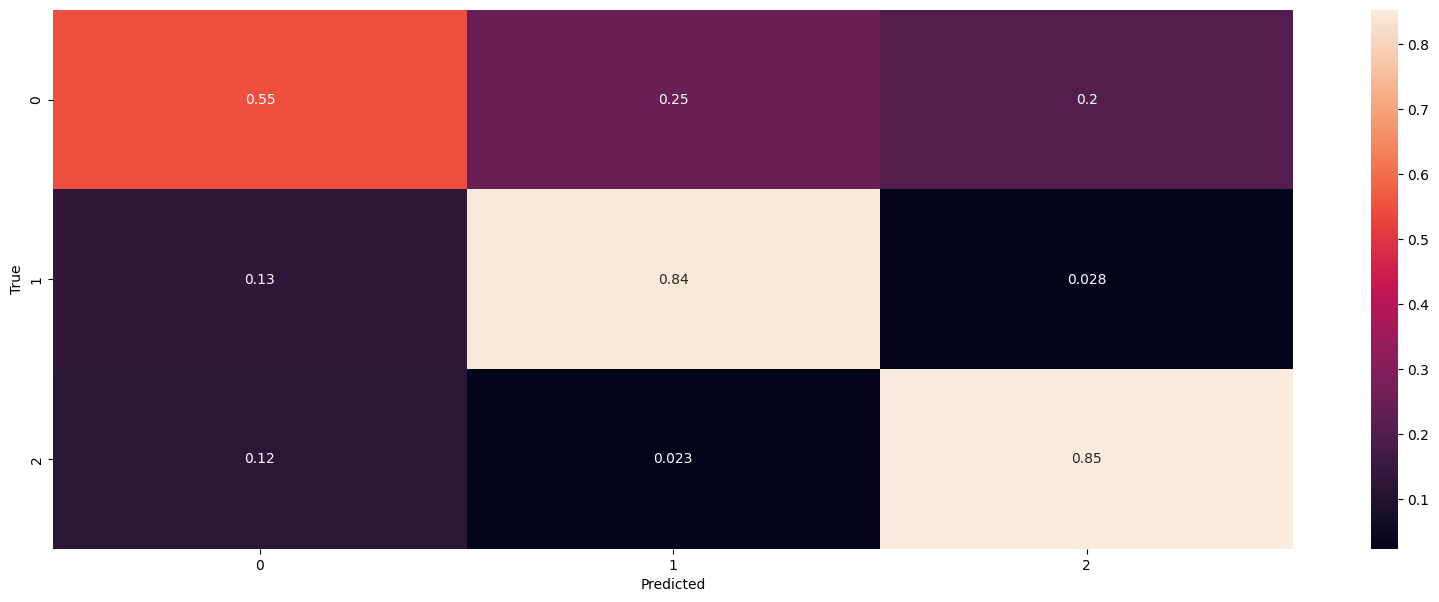

In [ ]:
cm = tf.math.confusion_matrix(bert_test_labels, cls_predictions)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")

##Bert CNN

In [ ]:
def create_bert_cnn_model(max_sequence_length=MAX_SEQUENCE_LENGTH,
                          num_filters = [100, 100, 50, 25],
                          kernel_sizes = [2, 3, 4, 5],
                          dropout = 0.3,
                          hidden_size = 100, 
                          learning_rate=0.00001):
    """
    Build a  classification model with BERT, where you apply CNN layers  to the BERT output
    """


    bert_model.trainable = True
    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      

    bert_out = bert_model(bert_inputs)[0]
  
    conv_layers_for_all_kernel_sizes = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(bert_out)
        conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(conv_layer)

    conv_output = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)

    dropout = keras.layers.Dropout(rate=dropout)(conv_output)

    hidden_output = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(dropout)

    classification = tf.keras.layers.Dense(3, activation='softmax',name='classification_layer')(hidden_output)
    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                                 metrics='accuracy')

    
    return classification_model

In [ ]:
bert_cnn_model = create_bert_cnn_model()
bert_cnn_model.summary()
#confirm all layers are frozen
bert_cnn_model_history = bert_cnn_model.fit(
    [bert_train_inputs[0], bert_train_inputs[1], bert_train_inputs[2]],
    bert_train_labels,
    validation_data=([bert_val_inputs[0], bert_val_inputs[1], bert_val_inputs[2]], bert_val_labels),
    batch_size=8,
    epochs=2)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                            

3462/3462 [==============================] - 863s 246ms/step - loss: 0.5562 - accuracy: 0.7533 - val_loss: 0.7996 - val_accuracy: 0.6606
Epoch 2/2
3462/3462 [==============================] - 845s 244ms/step - loss: 0.3995 - accuracy: 0.8326 - val_loss: 0.8230 - val_accuracy: 0.6459


In [ ]:
np.unique(bert_train_labels, return_counts = True)

(array([0, 1, 2]), array([ 8090,  7328, 12278]))

In [ ]:
cnn_predictions = bert_cnn_model.predict([bert_test_inputs[0], bert_test_inputs[1], bert_test_inputs[2]])
cnn_predictions = tf.argmax(cnn_predictions, axis=-1)

In [ ]:
print(classification_report(bert_test_labels, cnn_predictions))#, target_names=["Neutral", "Hateful", "Supportive"]))

              precision    recall  f1-score   support

           0       0.73      0.77      0.75      1750
           1       0.82      0.90      0.85      1576
           2       0.95      0.86      0.90      2609

    accuracy                           0.84      5935
   macro avg       0.83      0.84      0.83      5935
weighted avg       0.85      0.84      0.84      5935



Text(220.72222222222223, 0.5, 'True')

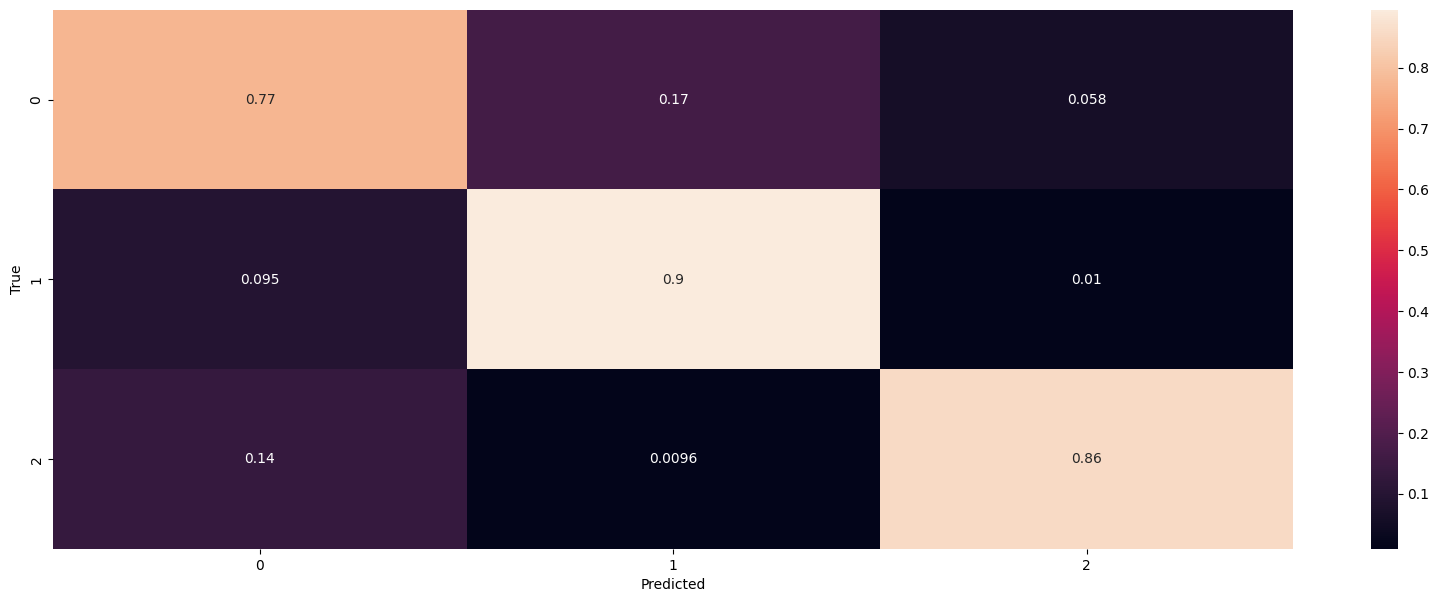

In [ ]:
cm = tf.math.confusion_matrix(bert_test_labels, cnn_predictions)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")

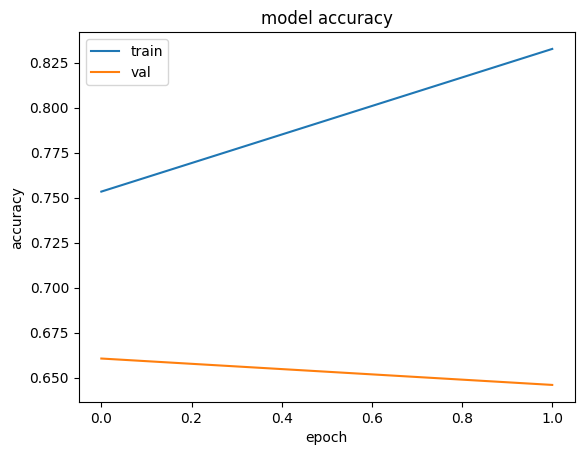

In [ ]:
from matplotlib import pyplot as plt
plt.plot(bert_cnn_model_history.history['accuracy'])
plt.plot(bert_cnn_model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xlim(.84, .96)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Combined Roberta Model


In [28]:
from transformers import RobertaConfig, TFRobertaModel

In [29]:
#Roberta Model, Tokenizer, and Train and Test Sets

roberta_tokenizer = AutoTokenizer.from_pretrained("roberta-base")
roberta_model = TFRobertaModel.from_pretrained("roberta-base")

MAX_SEQUENCE_LENGTH = 128
roberta_train_tokenized = roberta_tokenizer(list(train_examples),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              add_special_tokens=True,
              return_tensors='tf')
print(roberta_train_tokenized)
roberta_train_inputs = [roberta_train_tokenized.input_ids,
                     roberta_train_tokenized.attention_mask]
roberta_train_labels = np.array(train_labels)

roberta_val_tokenized = roberta_tokenizer(list(val_examples),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
roberta_val_inputs = [roberta_val_tokenized.input_ids,
                     roberta_val_tokenized.attention_mask]
roberta_val_labels = np.array(val_labels)

roberta_test_tokenized = roberta_tokenizer(list(test_examples),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
roberta_test_inputs = [roberta_test_tokenized.input_ids,
                     #roberta_test_tokenized.token_type_ids,
                     roberta_test_tokenized.attention_mask]
roberta_test_labels = np.array(test_labels)

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


{'input_ids': <tf.Tensor: shape=(27696, 128), dtype=int32, numpy=
array([[    0,  1039,  6785, ...,     1,     1,     1],
       [    0,  1039,   298, ...,     1,     1,     1],
       [    0, 20328,    47, ...,     1,     1,     1],
       ...,
       [    0,   597, 24029, ...,     1,     1,     1],
       [    0, 15698,   286, ...,     1,     1,     1],
       [    0, 37294,   219, ...,     1,     1,     1]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(27696, 128), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}


In [30]:
def create_roberta1_classification_model(max_sequence_length=MAX_SEQUENCE_LENGTH,
                          num_filters = [100, 100, 50, 25],
                          kernel_sizes = [2, 3, 4, 5],
                          dropout = 0.3,
                          hidden_size = 100, 
                          learning_rate=.00001):
    """
    Build a  classification model with BERT, where you apply CNN layers  to the BERT output
    """


    roberta_model.trainable = True
    #max_length = 100
    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
   # token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    roberta_inputs = {'input_ids': input_ids,
                   'attention_mask': attention_mask}      

    roberta_out = roberta_model(roberta_inputs)

    pooler_token = roberta_out[1]
    print(pooler_token)
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooler_token)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    classification = tf.keras.layers.Dense(3, activation='softmax',name='classification_layer')(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                                 metrics='accuracy')
    
    return classification_model

In [31]:
roberta1_classification_model = create_roberta1_classification_model()
roberta1_classification_model.summary()
#confirm all layers are frozen
roberta1_classification_model_history = roberta1_classification_model.fit(
    [roberta_train_inputs[0], roberta_train_inputs[1]],
    roberta_train_labels,
    validation_data=([roberta_test_inputs[0], roberta_test_inputs[1]], roberta_test_labels),
    batch_size=8,
    epochs=2)

KerasTensor(type_spec=TensorSpec(shape=(None, 768), dtype=tf.float32, name=None), name='tf_roberta_model/roberta/pooler/dense/Tanh:0', description="created by layer 'tf_roberta_model'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['attention_mask_layer[0][0]',   
 el)   

In [32]:
predictions1 = roberta1_classification_model.predict([roberta_test_inputs[0], roberta_test_inputs[1]])

In [ ]:
predictions1 = tf.argmax(predictions1, axis=-1)

In [34]:
from sklearn.metrics import classification_report
print(classification_report(roberta_test_labels, predictions1))#, target_names=["Neutral", "Hateful", "Supportive"]))

              precision    recall  f1-score   support

           0       0.58      0.59      0.59      1750
           1       0.70      0.83      0.76      1576
           2       0.88      0.78      0.83      2609

    accuracy                           0.74      5935
   macro avg       0.72      0.73      0.73      5935
weighted avg       0.75      0.74      0.74      5935



In [35]:
cm = tf.math.confusion_matrix(roberta_test_labels, predictions1)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(220.72222222222223, 0.5, 'True')

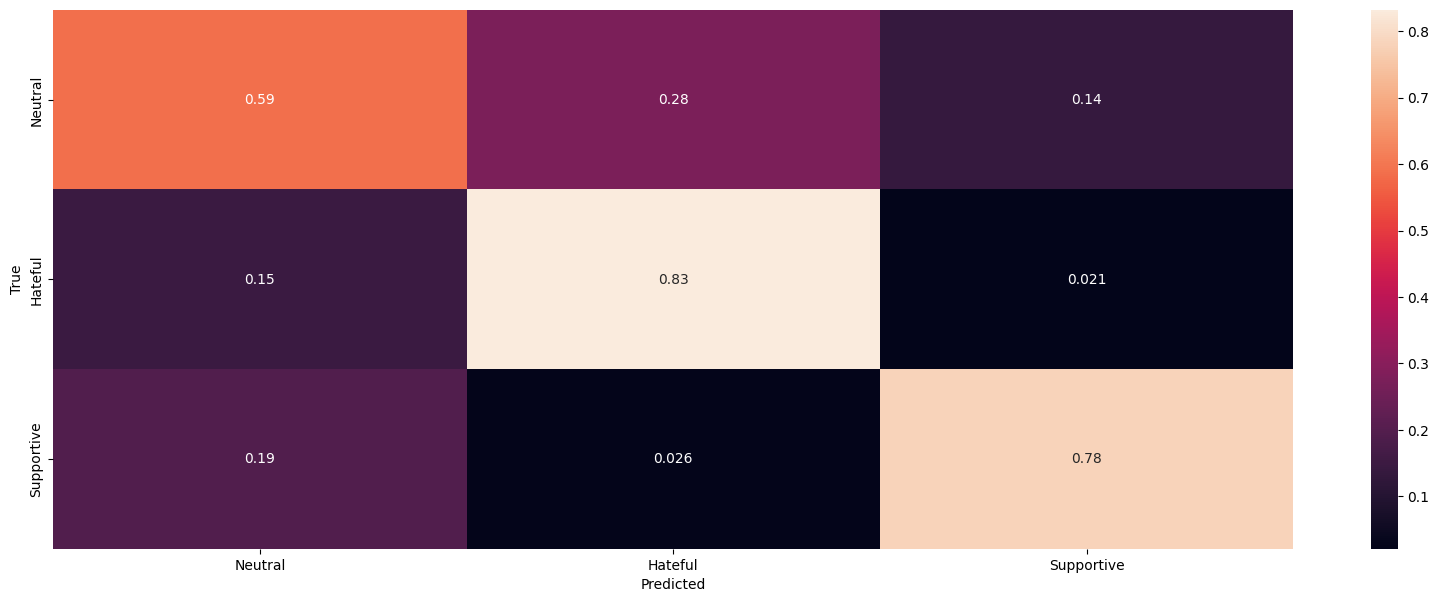

In [36]:
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=["Neutral", "Hateful", "Supportive"],
    yticklabels=["Neutral", "Hateful", "Supportive"])
plt.xlabel("Predicted")
plt.ylabel("True")

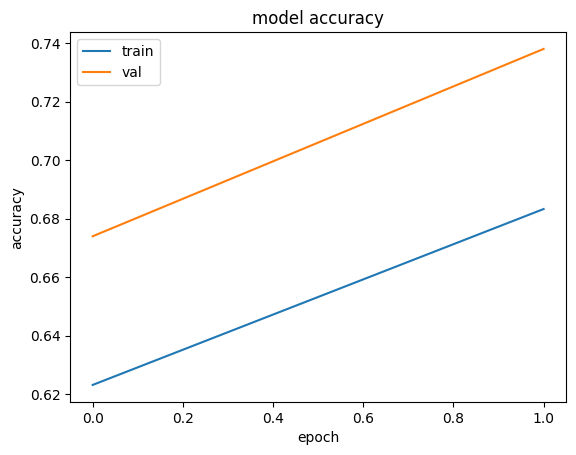

In [37]:
from matplotlib import pyplot as plt
plt.plot(roberta1_classification_model_history.history['accuracy'])
plt.plot(roberta1_classification_model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [38]:
MAX_SEQUENCE_LENGTH = 128
binary_roberta_train_tokenized = roberta_tokenizer(list(binary_train_examples),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
binary_roberta_train_inputs = [binary_roberta_train_tokenized.input_ids,
                     binary_roberta_train_tokenized.attention_mask]
binary_roberta_train_labels = np.array(binary_train_labels)

binary_roberta_val_tokenized = roberta_tokenizer(list(binary_val_examples),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
binary_roberta_val_inputs = [binary_roberta_val_tokenized.input_ids,
                     binary_roberta_val_tokenized.attention_mask]
binary_roberta_val_labels = np.array(binary_val_labels)

binary_roberta_test_tokenized = roberta_tokenizer(list(binary_test_examples),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
binary_roberta_test_inputs = [binary_roberta_test_tokenized.input_ids,
                     binary_roberta_test_tokenized.attention_mask]
binary_roberta_test_labels = np.array(binary_test_labels)

In [39]:
def create_roberta2_classification_model(max_sequence_length=MAX_SEQUENCE_LENGTH,
                          num_classes = 1,
                          dropout = 0.3,
                          hidden_size = 100, 
                          learning_rate=0.00001):
    """
    Build a  classification model with BERT, where you apply CNN layers  to the BERT output
    """


    roberta_model.trainable = True
    #max_length = 100
    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
   # token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    roberta_inputs = {'input_ids': input_ids,
                   'attention_mask': attention_mask}      

    roberta_out = roberta_model(roberta_inputs)

    cls_token = roberta_out[1]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    classification = tf.keras.layers.Dense(num_classes, activation='sigmoid',name='classification_layer')(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                                 metrics='accuracy')
    
    return classification_model

In [41]:
binary_roberta2_classification_model = create_roberta2_classification_model()
binary_roberta2_classification_model.summary()
#confirm all layers are frozen
binary_roberta2_classification_model_history = binary_roberta2_classification_model.fit(
    [binary_roberta_train_inputs[0], binary_roberta_train_inputs[1]],
    binary_roberta_train_labels,
    validation_data=([binary_roberta_val_inputs[0], binary_roberta_val_inputs[1]], binary_roberta_val_labels),
    batch_size=8,
    epochs=2)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['attention_mask_layer[0][0]',   
 el)                            thPoolingAndCrossAt               'input_ids_layer[0][0]']        
                                tentions(last_hidde                                         

In [43]:
binary_predictions2 = binary_roberta2_classification_model.predict([binary_roberta_test_inputs[0], binary_roberta_test_inputs[1]])

In [44]:
binary_predictions2 = [1 if i[0] > .5 else 0 for i in binary_predictions2]

In [45]:
print(classification_report(binary_roberta_test_labels, binary_predictions2))#, target_names=["Neutral", "Hateful", "Supportive"]))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      4359
           1       0.91      0.85      0.88      1576

    accuracy                           0.94      5935
   macro avg       0.93      0.91      0.92      5935
weighted avg       0.94      0.94      0.94      5935



In [46]:
cm = tf.math.confusion_matrix(binary_roberta_test_labels, binary_predictions2)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(220.72222222222223, 0.5, 'True')

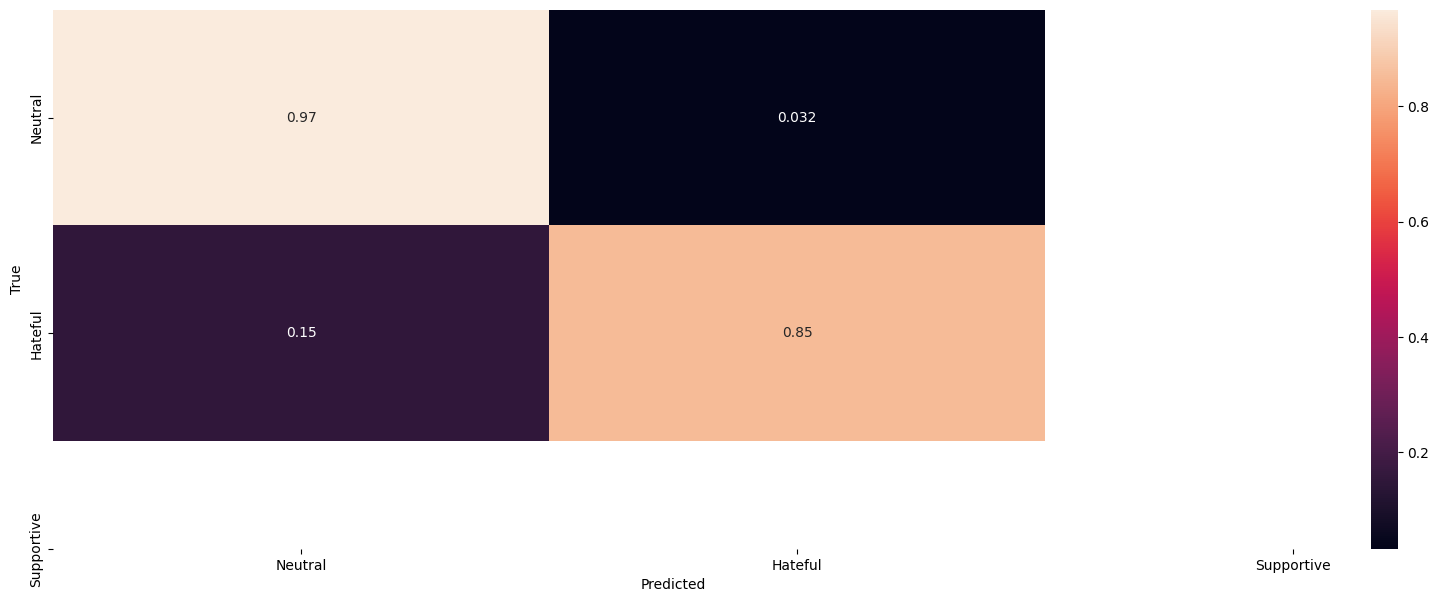

In [47]:
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=["Neutral", "Hateful", "Supportive"],
    yticklabels=["Neutral", "Hateful", "Supportive"])
plt.xlabel("Predicted")
plt.ylabel("True")

In [48]:
combined_preds = []
for i in range(len(predictions1)):
  if predictions1[i] == 0 and binary_predictions2[i] == 1:
    combined_preds.append(binary_predictions2[i])
  else:
    combined_preds.append(predictions1[i])
combined_preds = np.array(combined_preds)

In [49]:
print(len(predictions1))
print(len(binary_predictions2))

5935
5935


In [50]:
print(classification_report(roberta_test_labels, combined_preds))

              precision    recall  f1-score   support

           0       0.63      0.58      0.60      1750
           1       0.72      0.92      0.81      1576
           2       0.88      0.78      0.83      2609

    accuracy                           0.76      5935
   macro avg       0.74      0.76      0.75      5935
weighted avg       0.76      0.76      0.76      5935



In [51]:
plt.figure(figsize=(20,7))
cm = tf.math.confusion_matrix(roberta_test_labels, combined_preds)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

<Figure size 2000x700 with 0 Axes>

Text(220.72222222222223, 0.5, 'True')

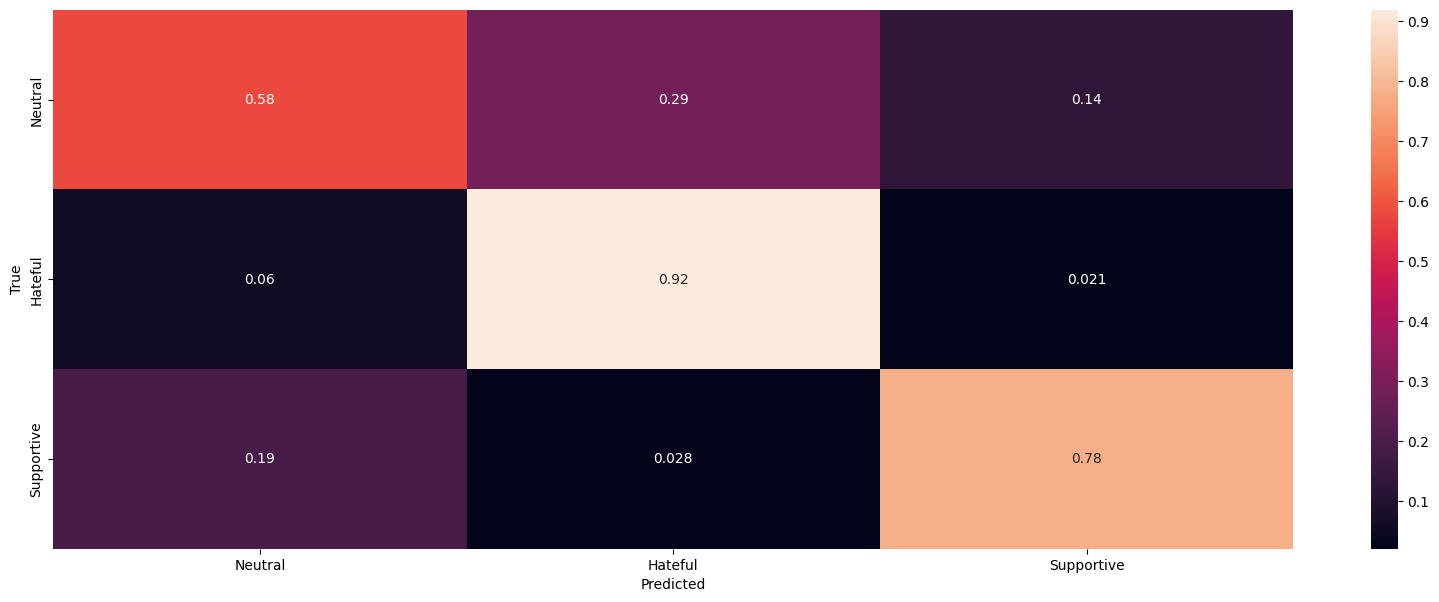

In [52]:
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=["Neutral", "Hateful", "Supportive"],
    yticklabels=["Neutral", "Hateful", "Supportive"])
plt.xlabel("Predicted")
plt.ylabel("True")

In [56]:
incorrects = []
for i in range(len(combined_preds)):
  if combined_preds[i] != roberta_test_labels[i]:
    prediction=combined_preds[i]
    label=roberta_test_labels[i]
    example = list(test_examples)[i]
    incorrects.append([prediction,label, example])


In [57]:
for i in range(10):
  print(f'Text {i}: ' , incorrects[i][2])
  print(f'Predicted Label {i}: ' , incorrects[i][0])
  print(f'True Label {i}: ' , incorrects[i][1])

Text 0:  It was used during beatings, rapes, and murders of black people
Predicted Label 0:  0
True Label 0:  2
Text 1:  It's not a shit hole because that's where the white people live. That kid wasn't white.
Predicted Label 1:  2
True Label 1:  0
Text 2:  Let me fuck you as your sucking your own pulsating cock
Predicted Label 2:  2
True Label 2:  0
Text 3:  @TylerTrollbane @penelope7usa Liberals: White genocide NOW! "Conservatives": Hold on! We need a phase-in so we can ASSIMILATE with them. White genocide must be done carefully, smoothly, and LEGALLY! "Libertarians": Slowing down genocide is COLLECTIVIST! And costs money! Leave GENOCIDE to the MARKET!
Predicted Label 3:  0
True Label 3:  1
Text 4:  After recent performance of India in icc tournament ( S.a smiles from a distance )  C H O K E R S
Predicted Label 4:  2
True Label 4:  0
Text 5:  The concept of "gendered brains" is demonstrably false through the very science that those mainstream atheists claim to respect so much, so all 